In [3]:
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")

data_dir = "./data/dogs_emotions/"
print("Path to dataset files:", data_dir)

Path to dataset files: ./data/dogs_emotions/


**dogs_emotions** directory contains 4 sub directory specifying the dog emotions in .jpg images accordingly:

1- angry directory containing images of angry dogs

2- happy directory containing images of happy dogs

3- relaxed directory containing images of relaxed dogs

4- sad directory containing images of sad dogs

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from collections import Counter
import os
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [4]:
image_sizes = {}
dataset_size = None

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('jpg')):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                size = img.size
                if size in image_sizes:
                    image_sizes[size] += 1
                else:
                    image_sizes[size] = 1

for size, count in image_sizes.items():
    print(f"Розмір {size}: {count} зображень")
    dataset_size = count

Розмір (384, 384): 15921 зображень
Розмір (128, 128): 2256 зображень


In [5]:

full_dataset = torchvision.datasets.ImageFolder(root=data_dir)

class_names = full_dataset.classes
print("Класи: ", class_names)
print(full_dataset.class_to_idx)

Класи:  ['angry', 'happy', 'relaxed', 'sad']
{'angry': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}


In [6]:
def dataset_statistics(dataset, classes, label):
    num_samples = len(dataset)
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    
    print(label)
    print("-----------------------------")
    print(f"🔹 Загальна кількість зображень: {num_samples}")
    print(f"🔹 Кількість класів: {len(classes)}")
    print("🔹 Список класів:")
    for i, cls in enumerate(classes):
        print(f"   {i}: {cls} ({label_counts[i]} зразків)")
    
    # Візуалізація розподілу класів
    plt.figure(figsize=(10, 5))
    plt.bar(classes, [label_counts[i] for i in range(len(classes))], color='skyblue')
    plt.xlabel("Класи")
    plt.ylabel("Кількість зразків")
    plt.title("Розподіл класів у наборі даних")
    plt.xticks(rotation=45)
    plt.show()


Огляд датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 18177
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (4512 зразків)
   1: happy (4784 зразків)
   2: relaxed (4349 зразків)
   3: sad (4532 зразків)


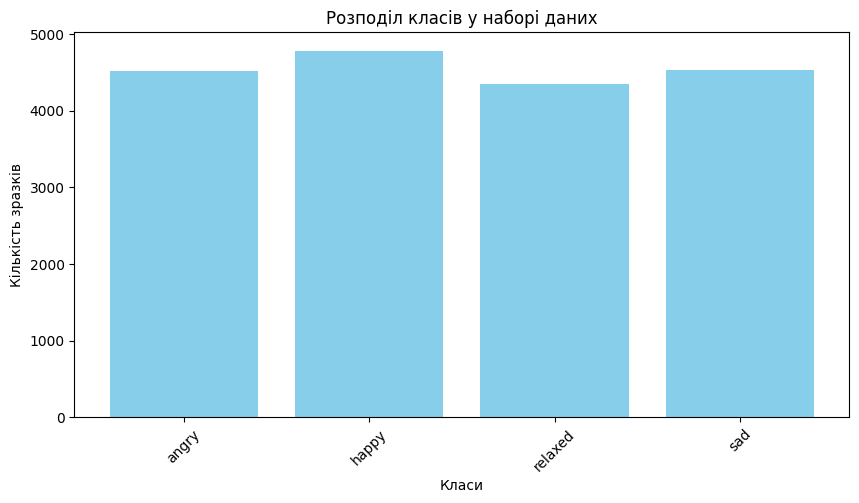

In [7]:
dataset_statistics(full_dataset, class_names, "Огляд датасету Dog Emotions")

In [8]:
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

In [12]:
# Define path
dataset_dir =  "./data/dogs_emotions/"
classes = sorted(os.listdir(dataset_dir))

# Collect all image file paths and corresponding class labels
filepaths = []
labels = []

for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        filepaths.append(os.path.join(class_name, fname))  # relative path
        labels.append(class_name)


In [17]:
# First split into train+val and test
trainval_paths, test_paths, trainval_labels, test_labels = train_test_split(
    filepaths, labels, test_size=0.15, stratify=labels, random_state=42)

# Then split trainval into train and val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    trainval_paths, trainval_labels, test_size=0.2, stratify=trainval_labels, random_state=42)


In [18]:
import pandas as pd

df_train = pd.DataFrame({'filename': train_paths, 'class': train_labels})
df_val = pd.DataFrame({'filename': val_paths, 'class': val_labels})
df_test = pd.DataFrame({'filename': test_paths, 'class': test_labels})


In [19]:
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory=dataset_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    df_val,
    directory=dataset_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    df_test,
    directory=dataset_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 10825 validated image filenames belonging to 4 classes.


c:\Users\Anna\Downloads\Projects\DeepLearning_KMA\hws\venv\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 2707 validated image filenames belonging to 4 classes.
Found 2389 validated image filenames belonging to 4 classes.


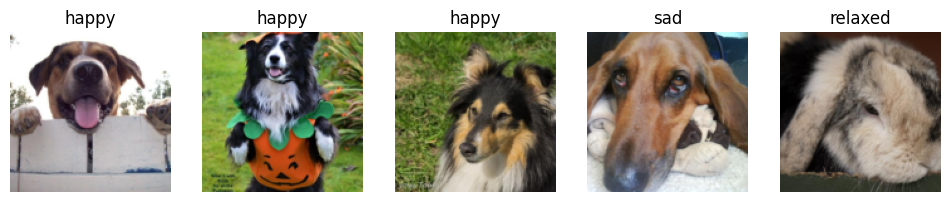

In [49]:
show_images(train_loader)

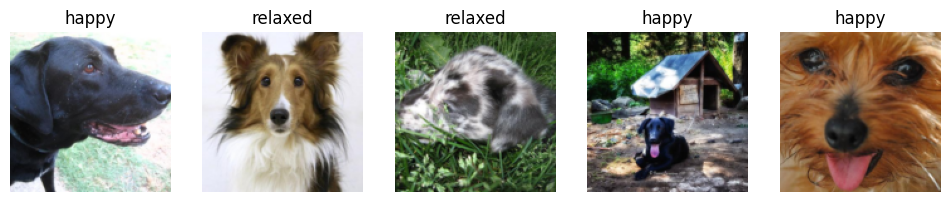

In [51]:
show_images(val_loader)

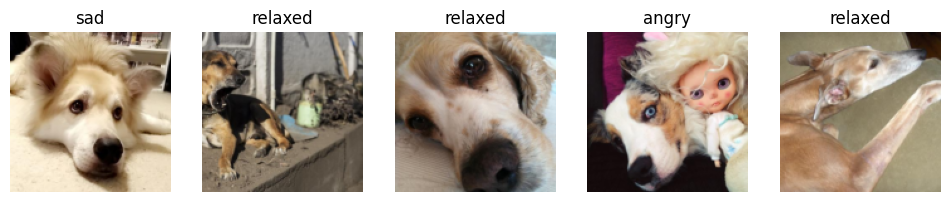

In [50]:
show_images(test_loader)

Огляд тренувального датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 12723
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (3143 зразків)
   1: happy (3369 зразків)
   2: relaxed (3055 зразків)
   3: sad (3156 зразків)


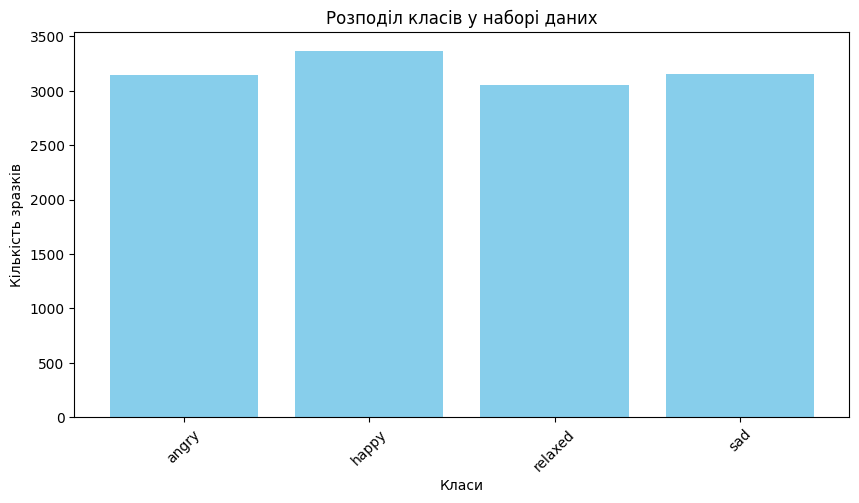

In [122]:
dataset_statistics(train_loader.dataset, class_names, "Огляд тренувального датасету Dog Emotions")

Огляд валідаційного датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 3635
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (914 зразків)
   1: happy (956 зразків)
   2: relaxed (866 зразків)
   3: sad (899 зразків)


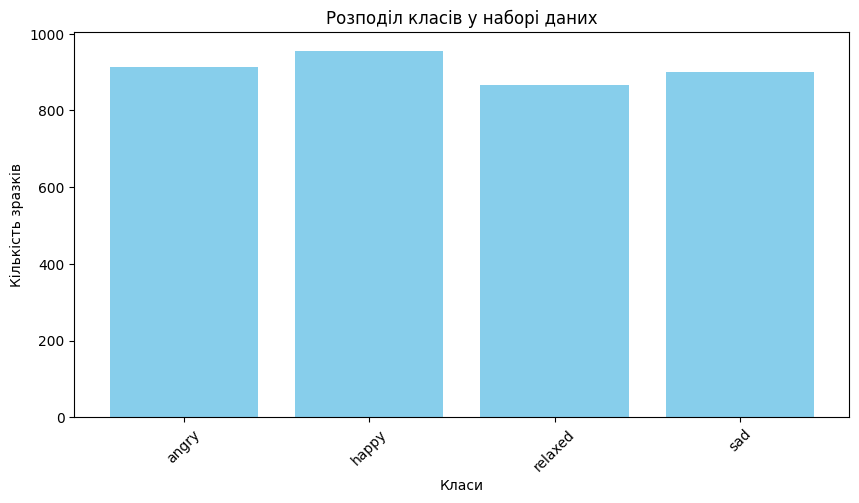

In [123]:
dataset_statistics(val_loader.dataset, class_names, "Огляд валідаційного датасету Dog Emotions")

Огляд тестувального датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 1819
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (455 зразків)
   1: happy (459 зразків)
   2: relaxed (428 зразків)
   3: sad (477 зразків)


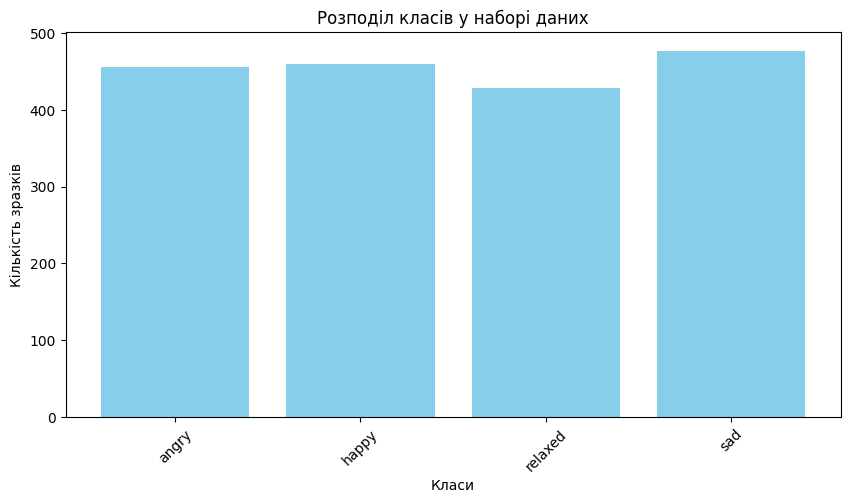

In [124]:
dataset_statistics(test_loader.dataset, class_names, "Огляд тестувального датасету Dog Emotions")

### **Планування на наступний етап**

#### **Метрики для оцінки ефективності**
- точність (Accuracy), частка правильних прогнозів
- F1-Score, комбінація precision and recall (especially in macro or weighted versions)


#### **Архітектура нейронної мережі**

- 3-4 згорткових шари

- ReLU активація для згорткових шарів, Softmax активація для вихідного шару

- 2-3 повнозв'язні шари

- оптимізатор Adam для адаптивного кроку навчання з weight_decay

- dropout 0.2-0.5 для запобігання перенавчанню

### Model

In [81]:
batch_size = 32
img_size = (64, 64)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 14544 images belonging to 4 classes.
Found 3633 images belonging to 4 classes.


In [69]:
from tensorflow.keras.regularizers import l2

weight_decay = 1e-4


In [70]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(*img_size, 3), kernel_regularizer=l2(weight_decay)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)),
    Dropout(0.5),
    Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay))
])

In [71]:
# from sklearn.metrics import F1Score, auc
# , tf.keras.metrics.F1Score(threshold=0.5, average='macro')
# from sklearn.metrics import confusion_matrix, classification_report


model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # make smaller during training
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 8, 8, 128)        

In [72]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # reduce by half
    patience=2,           # wait 2 epochs
    min_lr=1e-6,          # don’t go below this
    verbose=1
)


In [90]:
import pickle
from keras import backend as K

K.set_value(model.optimizer.lr, 0.000001)
epochs = 2

history_dict = {}
history_file = "training_history.pkl"
if os.path.exists(history_file):
    with open(history_file, "rb") as f:
        history_dict = pickle.load(f)
        print("Loaded previous training history.")

try:
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[lr_scheduler]
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving partial history...")
except Exception as e:
    print(f"Training failed: {e}")
finally:
    if history:
        # Append new history to existing history
        if 'loss' in history_dict:
            history_dict['loss'].extend(history.history['loss'])
            history_dict['val_loss'].extend(history.history['val_loss'])
            history_dict['accuracy'].extend(history.history['accuracy'])
            history_dict['val_accuracy'].extend(history.history['val_accuracy'])
        else:
            # If no previous history exists, initialize it
            history_dict = history.history
        
        # Save the updated history to file
        with open(history_file, "wb") as f:
            pickle.dump(history_dict, f)
        print("Updated training history saved to training_history.pkl")

Loaded previous training history.
Epoch 1/2
265/455 [================>.............] - ETA: 33s - loss: 1.2725 - accuracy: 0.4167Training interrupted. Saving partial history...
Updated training history saved to training_history.pkl


In [84]:
model.save("dog_emotion_cnn_model.h5")

c:\Users\Anna\Downloads\Projects\DeepLearning_KMA\hws\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


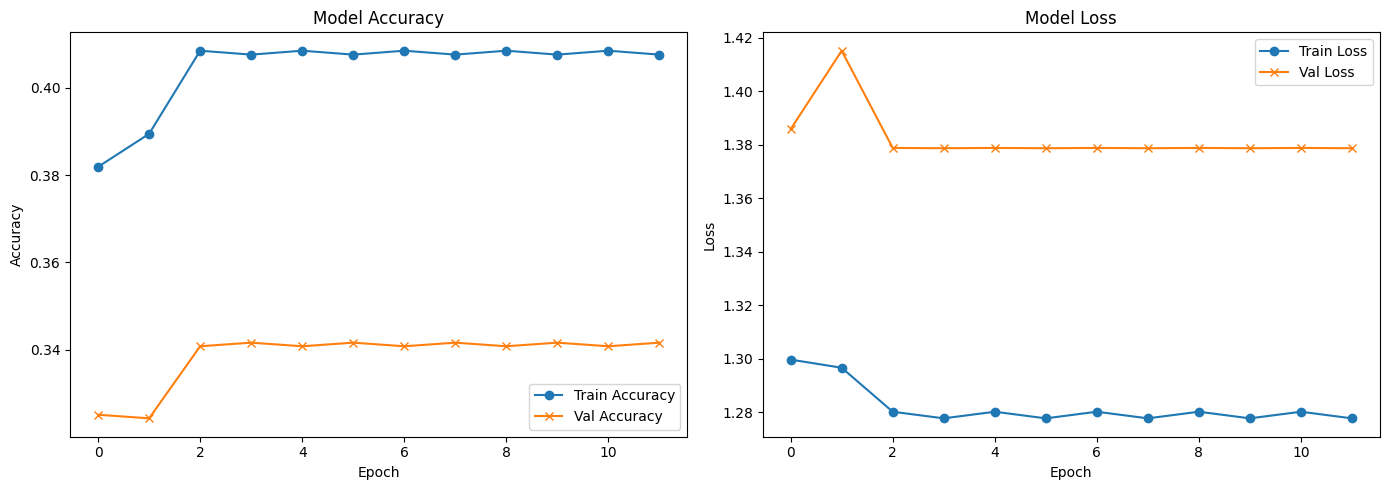

In [89]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# #  Option 2: Manually set learning rate between training runs
# # You can train for a few epochs, then stop and manually lower the learning rate, and continue training:
# from keras import backend as K

# # First run
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, epochs=10, validation_data=val_generator)

# # Change learning rate manually
# K.set_value(model.optimizer.lr, 0.0005)
# model.fit(train_generator, epochs=10, validation_data=val_generator)

# # Change again
# K.set_value(model.optimizer.lr, 0.0001)
# model.fit(train_generator, epochs=5, validation_data=val_generator)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Get predictions on validation or test data
# y_pred_probs = model.predict(val_generator)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Get true labels
# y_true = val_generator.classes

# # Print classification report
# print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# # Show confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(y_true, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
#             xticklabels=val_generator.class_indices.keys(), 
#             yticklabels=val_generator.class_indices.keys())
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()
